In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("data/train.csv")
train.head()

,id,name,popularity,duration_ms,artists,id_artists,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,release_year,release_month,release_day
0,269,blun7 a swishland,63,167760.0,['tha Supreme'],['19i93sA0D7yS9dYoVNBqAA'],0.692,0.792,7,-5.984,0.2450,0.1300,0.000000,0.2550,0.566,129.883,2019,11.0,15.0
1,27504,Que Me Perdone Tu Señora,42,150640.0,['Manoella Torres'],['4JRKcLbpjobmoOVoOXPd6y'],0.608,0.447,6,-12.151,0.0663,0.3350,0.000035,0.1690,0.673,90.777,2007,3.0,21.0
2,16082,愛唄~since 2007~,42,242373.0,['whiteeeen'],['6v3VFX2qIWthj4Lr5QIxts'],0.572,0.782,8,-5.275,0.0361,0.3060,0.000000,0.3740,0.450,170.050,2016,3.0,9.0
3,14585,Let me be your uncle tonight,12,202989.0,['Tvíhöfði'],['6rmrk3Jk0Ecf8fjioCCZmV'],0.855,0.470,7,-9.252,0.1620,0.0111,0.000002,0.2640,0.864,102.008,2001,1.0,1.0
4,14740,Never Going Back Again - 2004 Remaster,40,134400.0,['Fleetwood Mac'],['08GQAI4eElDnROBrJRGE0X'],0.654,0.336,6,-12.825,0.0379,0.8580,0.385000,0.0786,0.947,176.083,1977,2.0,4.0


In [3]:
artists = pd.read_csv("data/artists.csv")
artists.rename(columns={"popularity": "artist_popularity", "name": "artist_name", "id": "artist_id"}, inplace=True)
artists.head()

,artist_id,followers,genres,artist_name,artist_popularity
0,55CXG5KDJpRYwBopfYAJHa,21756,"['country blues', 'country rock', 'piedmont bl...",Jorma Kaukonen,40
1,08mjMUUjyTchMHCW7evc3R,640993,['turkish pop'],Hande Yener,62
2,3Ebn7mKYzD0L3DaUB1gNJZ,161509,"['celtic', 'irish folk']",Christy Moore,56
3,7GfaHcpmNcrcHoyGnOBsAz,9578,"['kindermusik', 'kleine hoerspiel']",Die Biene Maja,56
4,1DYXGLnfNDt8mO2aK9k83j,48876,"['opm', 'vispop']",Jay-R Siaboc,39


In [4]:
train.shape

(21000, 19)

In [5]:
train.columns

Index(['id', 'name', 'popularity', 'duration_ms', 'artists', 'id_artists',
       'danceability', 'energy', 'key', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'release_year', 'release_month', 'release_day'],
      dtype='object')

<AxesSubplot:>

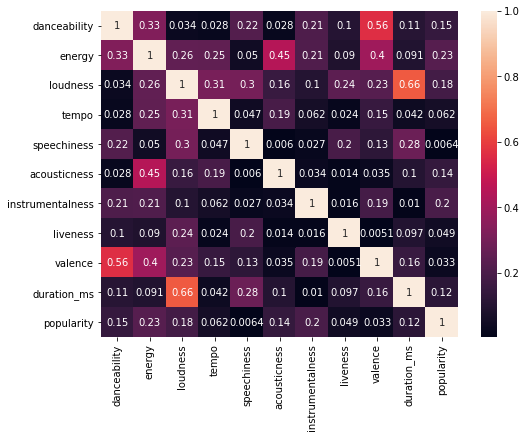

In [6]:
quant_cols = [
        'danceability', 'energy', 'loudness', 'tempo', 'speechiness',
        'acousticness', 'instrumentalness', 'liveness', 'valence', 'duration_ms',
        'popularity'
]
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(np.abs(np.log(train[quant_cols]).corr()), annot=True, ax=ax)

In [7]:
# Write a functiont that transforms raw data to design matrix
from sklearn.preprocessing import OneHotEncoder
oh_enc = OneHotEncoder()

def create_design_matrix(data, test=False):
    # Joining with the artists table
    df = data.copy()
    df['main_artist'] = (
        df['artists']
        .str.replace("[\[\]']+", "", regex=True)
        .str.split(",", expand=True)[0]
    )
    df['id_main_artist'] = (
        df['id_artists']
        .str.replace("[\[\]']+", "", regex=True)
        .str.split(",", expand=True)[0]
    )
    df = df.merge(artists, how='left', left_on='id_main_artist', right_on='artist_id')
    df.fillna(0, inplace=True)
    
    # One Hot Encode Release Decade
    df['release_decade'] = (df['release_year'] // 10) * 10
    if test:
        ohe_cols = pd.DataFrame(oh_enc.transform(df[['release_decade']]).todense(), 
                           columns=oh_enc.get_feature_names(),
                           index = df.index)
    else:
        ohe_cols = pd.DataFrame(oh_enc.fit_transform(df[['release_decade']]).todense(), 
                           columns=oh_enc.get_feature_names(),
                           index = df.index)
    df = df.join(ohe_cols)
    
    X = df.drop(columns=[
        'id', 'name', 'artists', 'id_artists', 'main_artist', 'id_main_artist', 'key',
        'release_year', 'release_month', 'release_day', 'artist_id', 'genres', 'artist_name', 'release_decade' 
    ])
    
    if not test:
        X = X.drop(columns=['popularity'])
    
    return X

In [8]:
# Try out an OLS model
from sklearn.linear_model import LinearRegression

models = {
    'ols': LinearRegression(),
}

# You can see the definition of evaluate_models in utils.py
evaluate_models(models, train, create_design_matrix)

ols CV Train RMSE: 12.563807334989706		ols CV Val RMSE: 12.579924623855248


In [9]:
# Make predictions on the test set
test = pd.read_csv("data/test.csv")
X_test = create_design_matrix(test, test=True)
preds = models['ols'].predict(X_test)
preds = np.clip(preds, a_min=0, a_max=100)    # 0 <= popularity <= 100
preds = np.rint(preds)    # round to nearest integer
preds[:20]

array([ 0., 24., 20., 29., 31., 29., 32., 22., 29., 27., 31., 35., 28.,
        9.,  0., 37., 23., 31., 16., 40.])

In [10]:
# Generate submission for Kaggle
submission_df = pd.DataFrame(data={
    'id': test['id'],
    'popularity': preds
})
submission_df

# Submit this CSV to the Kaggle competition (https://www.kaggle.com/c/sliced-s01e08-KJSEks/)
# submission_df.to_csv("submission.csv", index=False)

,id,popularity
0,21594,0.0
1,23733,24.0
2,17440,20.0
3,20756,29.0
4,29495,31.0
...,...,...
8995,27490,28.0
8996,22759,26.0
8997,1853,0.0
8998,1658,20.0
